<a href="https://colab.research.google.com/github/starkworld/Future-Sales-Prediction/blob/master/Future_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Loading Dataset

In [ ]:
item_cat = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/items.csv')
train = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/content/drive/My Drive/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
items = items.drop(['item_name'], axis=1)

## Printing range of columns of datasets

In [ ]:
print('Train')
for i in train.columns.values:
  print(f"{i}, {train[i].min()}, {train[i].max()}")

print('Items')
for j in items.columns.values:
  print(f'{j}, {items[j].min()}, {items[j].max()}')

print('Test')
for t in test.columns.values:
  print(f"{t}, {test[t].min()}, {test[t].max()}")

Train
date, 01.01.2013, 31.12.2014
date_block_num, 0, 33
shop_id, 0, 59
item_id, 0, 22169
item_price, -1.0, 307980.0
item_cnt_day, -22.0, 2169.0
Items
item_id, 0, 22169
item_category_id, 0, 83
Test
shop_id, 2, 59
item_id, 30, 22167


In [ ]:
train = pd.merge(train,items, on='item_id',how='left')
test = pd.merge(test,items,  on='item_id', how='left')

In [ ]:
display(train.shape, test.shape)

(2935849, 7)

(214200, 3)

## Showing the outliers of dataset

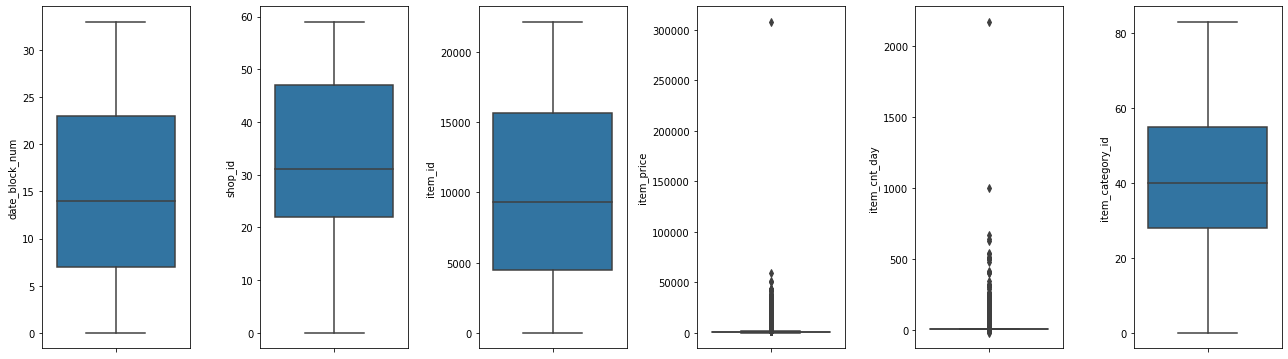

In [ ]:
columns = [ 'date_block_num', 'shop_id', 'item_id',  'item_price', 'item_cnt_day', 'item_category_id']
no_of_col = len(columns)
plt.figure(figsize=(3*no_of_col, 10))
for cat in range(0, no_of_col):
  plt.subplot(2, no_of_col, cat+1)
  sns.boxplot(train[columns[cat]], orient='v')
  plt.tight_layout()

### We will remove outliers which are greater than 10000 in item price and greater than 1000 in items day count

In [ ]:
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

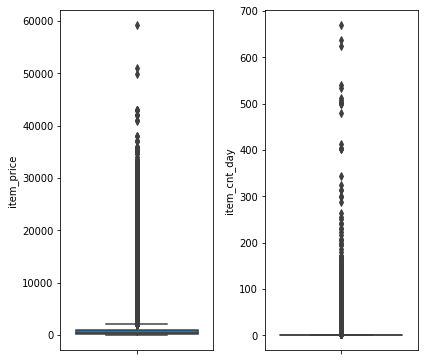

In [ ]:
columns = ['item_price', 'item_cnt_day']

no_of_col = len(columns)
plt.figure(figsize=(3*no_of_col, 10))
for cat in range(0, no_of_col):
  plt.subplot(2, no_of_col, cat+1)
  sns.boxplot(train[columns[cat]], orient='v')
  plt.tight_layout()

### Describing the correlation between independent variables and independent variable

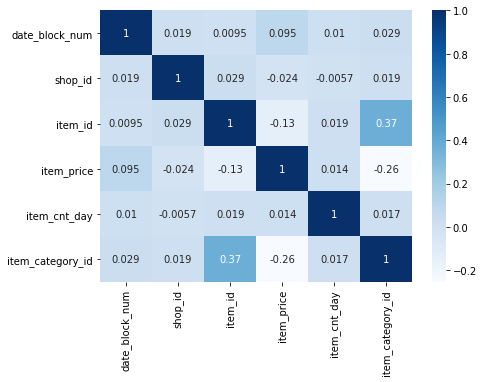

In [ ]:
columns = [ 'date_block_num', 'shop_id', 'item_id',  'item_price', 'item_cnt_day', 'item_category_id']
corr = train[columns].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns, annot=True, cmap='Blues')

Above heatmap indicates that dark coloured boxes represent positively correlated lighter boxes represent negitively correlated

creating a list containing shop_id, item_id associated with each block from 0 - 33

In [ ]:
train.shape
test.shape

(214200, 3)

In [ ]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
5,10.01.2013,0,25,2564,349.00,1.0,59
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55
2935845,09.10.2015,33,25,7460,299.00,1.0,55
2935846,14.10.2015,33,25,7459,349.00,1.0,55
2935847,22.10.2015,33,25,7440,299.00,1.0,57


For all the months we create blocks which consists details of items_id/shop_id pairs

In [ ]:
index_cols = ['shop_id','item_id','date_block_num']


grid_block = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num']==block_num,'shop_id'].unique()
    
    cur_items = train.loc[train['date_block_num']==block_num,'item_id'].unique()
    grid_block.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid_block = pd.DataFrame(np.vstack(grid_block),columns=index_cols,dtype=np.int32)
grid_block.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [ ]:
new_train = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
new_train = pd.merge(grid_block,new_train,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
new_train = pd.merge(new_train,items,on='item_id',how='left')
new_train

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,59,2552,0,0.0,0.0,58
2,59,2554,0,0.0,0.0,58
3,59,2555,0,0.0,0.0,56
4,59,2564,0,0.0,0.0,59
...,...,...,...,...,...,...
10884503,21,7635,33,0.0,0.0,64
10884504,21,7638,33,0.0,0.0,64
10884505,21,7640,33,0.0,0.0,64
10884506,21,7632,33,0.0,0.0,64


# Encoding Features

#### Here we use mean encoding technique which is similar to label encoding, except here labels are correlated directly with the target. For example, in mean target encoding for each category in the feature label is decided with the mean value of the target variable on a training data. This encoding method brings out the relation between similar categories, but the connections are bounded within the categories and target itself. The advantages of the mean target encoding are that it does not affect the volume of the data and helps in faster learning

In [ ]:
for id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = train.groupby([id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,id,'date_block_num']]
        mean_df.columns = [id+'_'+aggtype+'_'+column_id,id,'date_block_num']
        new_train = pd.merge(new_train, mean_df, on=['date_block_num',id], how='left')
        del mean_df

In [ ]:
for f in new_train.columns:
    if 'item_cnt' in f:
        new_train[f] = new_train[f].fillna(0)
    elif 'item_price' in f:
        new_train[f] = new_train[f].fillna(new_train[f].median())

In [ ]:
new_train

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,37,999.00,18.0,1.0,817.799565,2026.0,1.101686,465.066215,6132.0,1.066991
1,59,2552,0,0.0,0.0,58,899.00,1.0,1.0,817.799565,2026.0,1.101686,1407.577320,292.0,1.003436
2,59,2554,0,0.0,0.0,58,1709.05,1.0,1.0,817.799565,2026.0,1.101686,1407.577320,292.0,1.003436
3,59,2555,0,0.0,0.0,56,1098.85,2.0,1.0,817.799565,2026.0,1.101686,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,59,327.60,5.0,1.0,817.799565,2026.0,1.101686,440.204630,707.0,1.007123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10884503,21,7635,33,0.0,0.0,64,2100.00,1.0,1.0,1279.883887,1913.0,1.221584,1208.324415,875.0,1.024590
10884504,21,7638,33,0.0,0.0,64,1890.00,1.0,1.0,1279.883887,1913.0,1.221584,1208.324415,875.0,1.024590
10884505,21,7640,33,0.0,0.0,64,4040.00,1.0,1.0,1279.883887,1913.0,1.221584,1208.324415,875.0,1.024590
10884506,21,7632,33,0.0,0.0,64,2310.00,1.0,1.0,1279.883887,1913.0,1.221584,1208.324415,875.0,1.024590


Filling NAN values

In [ ]:
for f in new_train.columns:
  if 'item_cnt' in f:
        new_train[f] = new_train[f].fillna(0)
  elif 'item_price' in f:
        new_train[f] = new_train[f].fillna(new_train[f].median())

In [ ]:
new_train.isnull().values.any()

False

In [ ]:
new_train.shape

(10884508, 15)

In [ ]:
test.isnull().values.any()

False

In [ ]:
new_train = new_train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
test.head()

,shop_id,item_id,item_category_id
0,5,5037,19
1,5,5320,55
2,5,5233,19
3,5,5232,23
4,5,5268,20


In [ ]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,37,999.00,18.0,1.0,817.799565,2026.0,1.101686,465.066215,6132.0,1.066991
1,59,2552,0,0.0,0.0,58,899.00,1.0,1.0,817.799565,2026.0,1.101686,1407.577320,292.0,1.003436
2,59,2554,0,0.0,0.0,58,1709.05,1.0,1.0,817.799565,2026.0,1.101686,1407.577320,292.0,1.003436
3,59,2555,0,0.0,0.0,56,1098.85,2.0,1.0,817.799565,2026.0,1.101686,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,59,327.60,5.0,1.0,817.799565,2026.0,1.101686,440.204630,707.0,1.007123


In [ ]:
col_to_drop = ['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [ ]:
train_cols = new_train.columns.values
for c in col_to_drop:
    if c in train_cols:
        new_train = new_train.drop(c,axis=1)

In [ ]:
new_train.shape

(10884508, 5)